# 13장 파이토치 구조 자세히 알아보기

- 계산 그래프 이해하고 다루기
- 텐서 객체 다루기
- XOR문제 해결하고 모델의 수용 능력 이해하기

In [1]:
import torch 

In [14]:
def compute_z(a,b,c):
    r1 = torch.sub(a,b)
    r2 = torch.mul(r1 , 2)
    z = torch.add(r2 , c)
    return z

In [17]:
print('스칼라 입력 : ' , compute_z(torch.tensor(1) , 
                             torch.tensor(2) , torch.tensor(3)))
print('랭크 1 입력 : ' , compute_z(torch.tensor([1]) , 
                             torch.tensor([2]) , torch.tensor([3])))
print('랭크 2 입력 : ' , compute_z(torch.tensor([[1]]) , torch.tensor([[2]]) , torch.tensor([[3]])))

스칼라 입력 :  tensor(1)
랭크 1 입력 :  tensor([1])
랭크 2 입력 :  tensor([[1]])


# 파라미터를 저장 , 업데이트 하기 위한 파이토치 객체 
- require_grad = True라고 지정해놓으면 그레디언트 게산시 값이 업데이트 됨
- 현재는 부동소수점 , 복소수 dtype의 tensor만 그레디언트 요구가 가능

In [18]:
a = torch.tensor(3.14 , requires_grad = True) # 그레디언트의 대한 계산을 수행할지 안할지에 대한 결정코드 : requires_grad
a

tensor(3.1400, requires_grad=True)

In [20]:
b = torch.tensor([1.0 , 2.0 , 3.0] , requires_grad = True)
b

tensor([1., 2., 3.], requires_grad=True)

In [24]:
w = torch.tensor([1.0 , 2.0 , 3.0])
w.requires_grad

False

In [29]:
# 위에는 False로 나오는데 requires_grad_() <- 이렇게 _()까지 붙여주면 defalut값이 True가 됨
import torch.nn as nn
torch.manual_seed(1)
w = torch.empty(2,3) # 빈 텐서를 생성 
nn.init.xavier_normal_(w) # xavier 머시기 함수를 호출하면 글로럿 초기화를 따르는 값으로 빈 텐서를 채움
w

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])

In [31]:
# class내에 2개의 random값이 채워진 텐서를 생성해놓음 
# True로 되어있으니 기울기 게산할 때 자동으로 값이 업데이트 됨
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2,3, requires_grad = True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1,2, requires_grad = True)
        nn.init.xavier_normal_(self.w2)        

# 자동 미분으로 기울기 계산
### 연쇄법칙 이용

In [34]:
w = torch.tensor(1.0 , requires_grad = True)
b = torch.tensor(0.5 , requires_grad = True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w,x) , b)
loss = (y-z).pow(2).sum()
loss.backward()
print('dL / dw : ' , w.grad)
print('dL / db : ' , b.grad)

dL / dw :  tensor(-0.5600)
dL / db :  tensor(-0.4000)


In [35]:
# 계산된 그레디언트 확인
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


# nn.Sequential 기반의 모델 구현하기

In [38]:
model = nn.Sequential(
    nn.Linear(4,16),
    nn.ReLU(),
    nn.Linear(16 , 32),
    nn.ReLU()
)
model    

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [37]:
nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

In [41]:
# 손실 함수 선택하기
# 손실 함수의 선택은 문제에 따라 상이함
# 예를 들면 회귀문제에서는 MSE를 사용할 수 있음
# SGD optimizer와 이진분류를 위한 Cross entropy 손실 사용

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters() , lr = 0.001)

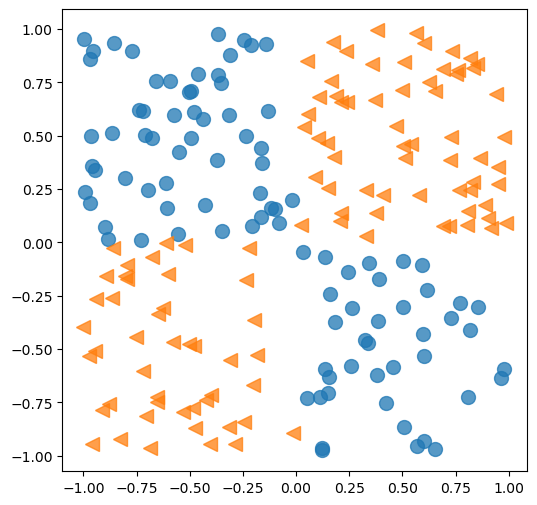

In [51]:
# XOR분류 문제 풀어보기

import matplotlib.pyplot as plt
import numpy as np 
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low = -1 , high = 1 , size = (200 , 2)) # [-1,1] 사이에 균등분포 200개 생성
y = np.ones(len(x)) # size : x의 len  
y[x[: ,0] * x[: , 1] < 0] = 0 # True = 1 / False = 0 조건문 , 이 조건문으로 y의 값 채움
n_train = 100
x_train = torch.tensor(x[:n_train, :] , dtype = torch.float32) 
y_train = torch.tensor(y[:n_train] , dtype = torch.float32)
x_valid = torch.tensor(x[n_train:, :] , dtype = torch.float32)
y_valid = torch.tensor(y[n_train:] , dtype = torch.float32)
fig = plt.figure(figsize = (6,6))
plt.plot(x[y==0,0] , x[y==0,1] , 'o' , alpha = 0.75 , markersize = 10) # x[y==0,0]  y == 0 인 원소의 index를 가져오고 그 index번호를 이용해서 x에 몇 행 , 몇 열의 원소를 가져와라 라는 명령어임
plt.plot(x[y==1,0] , x[y==1,1] , '<' , alpha = 0.75 , markersize = 10)
plt.show()

array([-0.99977125, -0.70648822, -0.62747958, -0.71922612,  0.60148914,
        0.7527783 , -0.82991158, -0.80330633,  0.91577906,  0.37300186,
        0.97772218, -0.79354799, -0.42444932, -0.57674377, -0.01685368,
        0.17861107, -0.79533114,  0.32758929,  0.88918951, -0.20464633,
        0.50162421,  0.76661218,  0.326883  , -0.18372639,  0.80675904,
        0.8170703 ,  0.38179384, -0.65531898,  0.86519093,  0.50775238,
       -0.96023973, -0.94338702,  0.7200559 ,  0.10564396, -0.75165337,
        0.17151854,  0.72708371, -0.88016462, -0.91089624,  0.94003998,
       -0.52030448,  0.23991144, -0.68641721, -0.85995571,  0.21265892,
        0.10189644, -0.86733033,  0.04934062, -0.47340646,  0.47013193,
        0.81563171, -0.97209685,  0.23355671,  0.90035224,  0.8312127 ,
       -0.21998457,  0.20862097,  0.85236285, -0.65208867, -0.64760749,
        0.16402836,  0.68946889,  0.57585847, -0.89218146,  0.35813767,
        0.2094322 ,  0.14942301,  0.50004353,  0.51016438, -0.23

array([[-1.65955991e-01,  4.40648987e-01],
       [-9.99771250e-01, -3.95334855e-01],
       [-7.06488218e-01, -8.15322810e-01],
       [-6.27479577e-01, -3.08878546e-01],
       [-2.06465052e-01,  7.76334680e-02],
       [-1.61610971e-01,  3.70439001e-01],
       [-5.91095501e-01,  7.56234873e-01],
       [-9.45224814e-01,  3.40935020e-01],
       [-1.65390395e-01,  1.17379657e-01],
       [-7.19226123e-01, -6.03797022e-01],
       [ 6.01489137e-01,  9.36523151e-01],
       [-3.73151644e-01,  3.84645231e-01],
       [ 7.52778305e-01,  7.89213327e-01],
       [-8.29911577e-01, -9.21890434e-01],
       [-6.60339161e-01,  7.56285007e-01],
       [-8.03306332e-01, -1.57784750e-01],
       [ 9.15779060e-01,  6.63305699e-02],
       [ 3.83754228e-01, -3.68968738e-01],
       [ 3.73001855e-01,  6.69251344e-01],
       [-9.63423445e-01,  5.00288630e-01],
       [ 9.77722178e-01,  4.96331309e-01],
       [-4.39112016e-01,  5.78558657e-01],
       [-7.93547987e-01, -1.04212948e-01],
       [ 8.